In [105]:
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16 as VGG
from keras.applications.densenet import DenseNet201 as DenseNet
from keras import optimizers
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

import numpy as np
from skimage.io import imread
from skimage.util import pad
from keras.models import load_model
import gdal
from tqdm import tqdm
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

import matplotlib.pyplot as plt

In [106]:
def preprocessing_image_rgb(x):
    # define mean and std values
    mean = [87.845, 96.965, 103.947]
    std = [23.657, 16.474, 13.793]
    # loop over image channels
    for idx, mean_value in enumerate(mean):
        x[..., idx] -= mean_value
        x[..., idx] /= std[idx]
    return x


In [107]:
path_to_split_datasets = "~/New"
use_vgg = True
batch_size = 64
path_to_home = os.path.expanduser("C:/Users/user/Desktop/PROJECT_TJ")
path_to_split_datasets = path_to_split_datasets.replace("~", path_to_home)

path_to_train = os.path.join(path_to_split_datasets, "category")

path_to_validation = os.path.join(path_to_split_datasets, "validation")

path_to_test = os.path.join(path_to_split_datasets, "test")

sub_dirs = [sub_dir for sub_dir in os.listdir(path_to_train)
            if os.path.isdir(os.path.join(path_to_train, sub_dir))]

num_classes=(len(sub_dirs))

In [108]:
path_to_split_datasets, path_to_train, path_to_validation, path_to_test, num_classes

('C:/Users/user/Desktop/PROJECT_TJ/New',
 'C:/Users/user/Desktop/PROJECT_TJ/New\\category',
 'C:/Users/user/Desktop/PROJECT_TJ/New\\validation',
 'C:/Users/user/Desktop/PROJECT_TJ/New\\test',
 3)

In [109]:
if use_vgg:
    base_model = VGG(include_top = False,
                     weights = 'imagenet',
                    input_shape=(78,78,3))
else:
    base_model = DenseNet(include_top = False,
                          weights = 'imagenet',
                          input_shape=(78,78,3))

In [110]:
top_model = base_model.output
top_model = GlobalAveragePooling2D()(top_model)
if use_vgg:
    top_model = Dense(2048, activation='relu')(top_model)
    top_model = Dense(2048, activation='relu')(top_model)
predictions = Dense(num_classes, activation='softmax')(top_model)
model = Model(inputs=base_model.input, outputs=predictions)

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 78, 78, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 78, 78, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 78, 78, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 39, 39, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 39, 39, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 39, 39, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 19, 19, 128)       0         
__________

In [112]:
train_datagen = ImageDataGenerator(fill_mode="reflect",
                                    rotation_range=45,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range = 0.5,
                                    zoom_range = 0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    preprocessing_function=preprocessing_image_rgb)

In [113]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_image_rgb)

In [114]:
train_generator = train_datagen.flow_from_directory(path_to_train,
                                                    target_size=(78,78),
                                                    batch_size=batch_size,
                                                    class_mode = 'categorical')

Found 1009 images belonging to 3 classes.


In [115]:
class_indices = train_generator.class_indices
print(class_indices)

{'high': 0, 'midium': 2, 'low': 1}


In [116]:
validation_generator = test_datagen.flow_from_directory(path_to_validation, 
                                                        target_size=(78, 78), 
                                                        batch_size=batch_size, 
                                                        class_mode='categorical')

Found 120 images belonging to 3 classes.


In [117]:
test_generator = test_datagen.flow_from_directory(path_to_test, 
                                                        target_size=(78, 78), 
                                                        batch_size=batch_size, 
                                                        class_mode='categorical')

Found 240 images belonging to 3 classes.


In [118]:
for layer in base_model.layers:
    layer.trainable = False

In [119]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [120]:
if use_vgg:
    file_name = "vgg"

else:
    file_name = "dense"

In [121]:
checkpointer = ModelCheckpoint("C:/Users/user/Desktop/PROJECT_TJ/New/" + file_name + 
                               "_rgb_transfer_init." + 
                              "{epoch:02d}-{val_categorical_accuracy:.3f}." +
                               "hdf5",
                               monitor='val_categorical_accuracy',
                               verbose=1,
                               mode='max')

In [122]:
earlystopper = EarlyStopping(monitor='val_categorical_accuracy', 
                             patience=10, 
                             mode='max', 
                             restore_best_weights=True)

In [123]:
tensorboard = TensorBoard(log_dir='./logs', write_graph=True, write_grads=True, 
                          write_images=True, update_freq='epoch')

In [124]:
history = model.fit_generator(train_generator, 
                               steps_per_epoch=100, 
                               epochs=10, 
                               callbacks=[checkpointer, earlystopper, 
                                          tensorboard], 
                               validation_data=validation_generator, 
                               validation_steps=50)

Epoch 1/10
100/100 [==============================] - ETA: 40s - loss: 1.1814 - categorical_accuracy: 0.234 - ETA: 18s - loss: 2.8238 - categorical_accuracy: 0.291 - ETA: 17s - loss: 2.6056 - categorical_accuracy: 0.273 - ETA: 16s - loss: 2.3677 - categorical_accuracy: 0.306 - ETA: 15s - loss: 2.1392 - categorical_accuracy: 0.333 - ETA: 15s - loss: 1.9712 - categorical_accuracy: 0.370 - ETA: 14s - loss: 1.8454 - categorical_accuracy: 0.384 - ETA: 14s - loss: 1.7445 - categorical_accuracy: 0.408 - ETA: 13s - loss: 1.6638 - categorical_accuracy: 0.417 - ETA: 13s - loss: 1.5985 - categorical_accuracy: 0.436 - ETA: 12s - loss: 1.5382 - categorical_accuracy: 0.447 - ETA: 12s - loss: 1.4803 - categorical_accuracy: 0.457 - ETA: 12s - loss: 1.4334 - categorical_accuracy: 0.469 - ETA: 12s - loss: 1.3949 - categorical_accuracy: 0.482 - ETA: 11s - loss: 1.3846 - categorical_accuracy: 0.478 - ETA: 11s - loss: 1.3780 - categorical_accuracy: 0.471 - ETA: 11s - loss: 1.3479 - categorical_accuracy: 0.

100/100 [==============================] - ETA: 3s - loss: 0.7246 - categorical_accuracy: 0.65 - ETA: 3s - loss: 0.6899 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.6860 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.6845 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.7197 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.7367 - categorical_accuracy: 0.66 - ETA: 3s - loss: 0.7146 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.7103 - categorical_accuracy: 0.66 - ETA: 3s - loss: 0.7097 - categorical_accuracy: 0.67 - ETA: 4s - loss: 0.7035 - categorical_accuracy: 0.67 - ETA: 4s - loss: 0.7025 - categorical_accuracy: 0.67 - ETA: 4s - loss: 0.7024 - categorical_accuracy: 0.67 - ETA: 4s - loss: 0.7054 - categorical_accuracy: 0.67 - ETA: 4s - loss: 0.7019 - categorical_accuracy: 0.67 - ETA: 5s - loss: 0.6995 - categorical_accuracy: 0.67 - ETA: 5s - loss: 0.6969 - categorical_accuracy: 0.67 - ETA: 5s - loss: 0.7064 - categorical_accuracy: 0.66 - ETA: 5s - loss: 0.7094 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.4699 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5932 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.6056 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.6557 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.6594 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.6420 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.6339 - categorical_accuracy: 0.68 - ETA: 3s - loss: 0.6420 - categorical_accuracy: 0.68 - ETA: 4s - loss: 0.6358 - categorical_accuracy: 0.69 - ETA: 4s - loss: 0.6349 - categorical_accuracy: 0.69 - ETA: 4s - loss: 0.6357 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6436 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6444 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6391 - categorical_accuracy: 0.69 - ETA: 5s - loss: 0.6446 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6491 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6539 - categorical_accuracy: 0.68 - ETA: 5s - loss: 0.6524 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.5839 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.6666 - categorical_accuracy: 0.70 - ETA: 3s - loss: 0.6737 - categorical_accuracy: 0.67 - ETA: 3s - loss: 0.6687 - categorical_accuracy: 0.68 - ETA: 3s - loss: 0.6324 - categorical_accuracy: 0.70 - ETA: 3s - loss: 0.6472 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.6591 - categorical_accuracy: 0.69 - ETA: 3s - loss: 0.6612 - categorical_accuracy: 0.68 - ETA: 4s - loss: 0.6542 - categorical_accuracy: 0.69 - ETA: 4s - loss: 0.6494 - categorical_accuracy: 0.69 - ETA: 5s - loss: 0.6486 - categorical_accuracy: 0.69 - ETA: 5s - loss: 0.6442 - categorical_accuracy: 0.69 - ETA: 5s - loss: 0.6372 - categorical_accuracy: 0.70 - ETA: 5s - loss: 0.6440 - categorical_accuracy: 0.70 - ETA: 5s - loss: 0.6418 - categorical_accuracy: 0.70 - ETA: 5s - loss: 0.6372 - categorical_accuracy: 0.70 - ETA: 5s - loss: 0.6381 - categorical_accuracy: 0.70 - ETA: 5s - loss: 0.6363 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.6195 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5969 - categorical_accuracy: 0.71 - ETA: 3s - loss: 0.6058 - categorical_accuracy: 0.72 - ETA: 3s - loss: 0.5975 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.6032 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.6024 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.6008 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5978 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.6093 - categorical_accuracy: 0.73 - ETA: 4s - loss: 0.6130 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.6226 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.6211 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.6188 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.6165 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.6176 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.6199 - categorical_accuracy: 0.72 - ETA: 6s - loss: 0.6141 - categorical_accuracy: 0.72 - ETA: 6s - loss: 0.6147 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.6046 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.6232 - categorical_accuracy: 0.70 - ETA: 3s - loss: 0.6014 - categorical_accuracy: 0.71 - ETA: 3s - loss: 0.5815 - categorical_accuracy: 0.72 - ETA: 3s - loss: 0.6009 - categorical_accuracy: 0.71 - ETA: 3s - loss: 0.6096 - categorical_accuracy: 0.71 - ETA: 3s - loss: 0.6091 - categorical_accuracy: 0.71 - ETA: 3s - loss: 0.6057 - categorical_accuracy: 0.71 - ETA: 4s - loss: 0.6008 - categorical_accuracy: 0.71 - ETA: 4s - loss: 0.5908 - categorical_accuracy: 0.72 - ETA: 5s - loss: 0.6005 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.6005 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.5990 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.6001 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.5992 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.5961 - categorical_accuracy: 0.71 - ETA: 5s - loss: 0.5916 - categorical_accuracy: 0.71 - ETA: 6s - loss: 0.5888 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.6230 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5685 - categorical_accuracy: 0.78 - ETA: 3s - loss: 0.5585 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5743 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5705 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5812 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.5716 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.5661 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5616 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5671 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5635 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5609 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5691 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5738 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5733 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5783 - categorical_accuracy: 0.73 - ETA: 5s - loss: 0.5785 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5880 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.7979 - categorical_accuracy: 0.62 - ETA: 3s - loss: 0.6265 - categorical_accuracy: 0.72 - ETA: 3s - loss: 0.5309 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5242 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.5184 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5196 - categorical_accuracy: 0.78 - ETA: 3s - loss: 0.5260 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5270 - categorical_accuracy: 0.76 - ETA: 4s - loss: 0.5237 - categorical_accuracy: 0.76 - ETA: 4s - loss: 0.5254 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5303 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5387 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5449 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5536 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5601 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5642 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5636 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5641 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.4744 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.4785 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.4635 - categorical_accuracy: 0.78 - ETA: 3s - loss: 0.4954 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.5230 - categorical_accuracy: 0.74 - ETA: 3s - loss: 0.5477 - categorical_accuracy: 0.73 - ETA: 3s - loss: 0.5520 - categorical_accuracy: 0.73 - ETA: 4s - loss: 0.5443 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5456 - categorical_accuracy: 0.74 - ETA: 4s - loss: 0.5567 - categorical_accuracy: 0.73 - ETA: 5s - loss: 0.5557 - categorical_accuracy: 0.73 - ETA: 5s - loss: 0.5531 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5510 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5577 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5556 - categorical_accuracy: 0.74 - ETA: 5s - loss: 0.5494 - categorical_accuracy: 0.74 - ETA: 6s - loss: 0.5553 - categorical_accuracy: 0.73 - ETA: 6s - loss: 0.5540 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.4630 - categorical_accuracy: 0.78 - ETA: 3s - loss: 0.4977 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5086 - categorical_accuracy: 0.77 - ETA: 3s - loss: 0.5171 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.5368 - categorical_accuracy: 0.75 - ETA: 3s - loss: 0.5197 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.5278 - categorical_accuracy: 0.76 - ETA: 3s - loss: 0.5349 - categorical_accuracy: 0.75 - ETA: 4s - loss: 0.5358 - categorical_accuracy: 0.75 - ETA: 4s - loss: 0.5306 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5286 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5211 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5226 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5210 - categorical_accuracy: 0.75 - ETA: 5s - loss: 0.5149 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5121 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5199 - categorical_accuracy: 0.76 - ETA: 5s - loss: 0.5225 - categorical_ac

In [130]:
initial_epoch = len(history.history['loss'])+1

In [131]:
initial_epoch

11

In [132]:
names = []

In [133]:
for i, layer in enumerate(model.layers): 
    names.append([i, layer.name, layer.trainable])

In [134]:
print(names)

[[0, 'input_3', False], [1, 'block1_conv1', False], [2, 'block1_conv2', False], [3, 'block1_pool', False], [4, 'block2_conv1', False], [5, 'block2_conv2', False], [6, 'block2_pool', False], [7, 'block3_conv1', False], [8, 'block3_conv2', False], [9, 'block3_conv3', False], [10, 'block3_pool', False], [11, 'block4_conv1', False], [12, 'block4_conv2', False], [13, 'block4_conv3', False], [14, 'block4_pool', False], [15, 'block5_conv1', False], [16, 'block5_conv2', False], [17, 'block5_conv3', False], [18, 'block5_pool', False], [19, 'global_average_pooling2d_4', True], [20, 'dense_9', True], [21, 'dense_10', True], [22, 'dense_11', True]]


In [135]:
if use_vgg: 
     for layer in model.layers[:4]: 
            layer.trainable = False 
     for layer in model.layers[4:]: 
         layer.trainable = True 
else: 
     for layer in model.layers[:7]: 
             layer.trainable = False 
     for layer in model.layers[7:]: 
             layer.trainable = True

In [136]:
model.compile(optimizer=optimizers.RMSprop(lr=0.0001), 
               loss='categorical_crossentropy', 
               metrics=['categorical_accuracy'])

In [137]:
if use_vgg: 
     file_name = "vgg" 
else: 
     file_name = "dense"

In [138]:
checkpointer = ModelCheckpoint("C:/Users/user/Desktop/PROJECT_TJ/New/" + file_name + 
                                "_rgb_transfer_final." + 
                                "{epoch:02d}-{val_categorical_accuracy:.3f}" + 
                                ".hdf5", 
                                monitor='val_categorical_accuracy', 
                                verbose=1, 
                                mode='max')

In [139]:
earlystopper = EarlyStopping(monitor='val_categorical_accuracy', 
                              patience=50, 
                              mode='max')

In [141]:
history2 = model.fit_generator(train_generator, 
                    steps_per_epoch=100, 
                    epochs=30, 
                    callbacks=[checkpointer, earlystopper, tensorboard], 
                    validation_data=validation_generator, 
                    validation_steps=500, 
                    initial_epoch=initial_epoch)

Epoch 12/30
100/100 [==============================] - ETA: 28s - loss: 0.5198 - categorical_accuracy: 0.781 - ETA: 20s - loss: 0.4980 - categorical_accuracy: 0.778 - ETA: 19s - loss: 0.5203 - categorical_accuracy: 0.758 - ETA: 20s - loss: 0.5021 - categorical_accuracy: 0.764 - ETA: 19s - loss: 0.5096 - categorical_accuracy: 0.755 - ETA: 17s - loss: 0.4971 - categorical_accuracy: 0.759 - ETA: 16s - loss: 0.4994 - categorical_accuracy: 0.767 - ETA: 16s - loss: 0.4966 - categorical_accuracy: 0.768 - ETA: 15s - loss: 0.5044 - categorical_accuracy: 0.765 - ETA: 14s - loss: 0.5044 - categorical_accuracy: 0.755 - ETA: 14s - loss: 0.5120 - categorical_accuracy: 0.753 - ETA: 13s - loss: 0.7791 - categorical_accuracy: 0.722 - ETA: 13s - loss: 0.7706 - categorical_accuracy: 0.723 - ETA: 13s - loss: 0.7563 - categorical_accuracy: 0.728 - ETA: 12s - loss: 0.7441 - categorical_accuracy: 0.727 - ETA: 12s - loss: 0.7265 - categorical_accuracy: 0.734 - ETA: 12s - loss: 0.7051 - categorical_accuracy: 0

100/100 [==============================] - ETA: 7s - loss: 0.4463 - categorical_accuracy: 0.76 - ETA: 7s - loss: 0.5413 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5643 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5789 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5462 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5381 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5382 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5346 - categorical_accuracy: 0.76 - ETA: 7s - loss: 0.5290 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5288 - categorical_accuracy: 0.74 - ETA: 7s - loss: 0.5253 - categorical_accuracy: 0.74 - ETA: 7s - loss: 0.5498 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5440 - categorical_accuracy: 0.74 - ETA: 6s - loss: 0.5450 - categorical_accuracy: 0.75 - ETA: 6s - loss: 0.5397 - categorical_accuracy: 0.75 - ETA: 6s - loss: 0.5343 - categorical_accuracy: 0.75 - ETA: 6s - loss: 0.5358 - categorical_accuracy: 0.75 - ETA: 6s - loss: 0.5288 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.5084 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5096 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.4497 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4423 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4621 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.4616 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4527 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4608 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4530 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4499 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4475 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4762 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.4839 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.4986 - categorical_accuracy: 0.77 - ETA: 6s - loss: 0.4979 - categorical_accuracy: 0.77 - ETA: 6s - loss: 0.4931 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.4922 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.4902 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.6121 - categorical_accuracy: 0.70 - ETA: 7s - loss: 0.6112 - categorical_accuracy: 0.72 - ETA: 7s - loss: 0.6157 - categorical_accuracy: 0.71 - ETA: 7s - loss: 0.6110 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.6281 - categorical_accuracy: 0.72 - ETA: 7s - loss: 0.6349 - categorical_accuracy: 0.72 - ETA: 7s - loss: 0.6156 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5903 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.5744 - categorical_accuracy: 0.74 - ETA: 7s - loss: 0.5586 - categorical_accuracy: 0.74 - ETA: 7s - loss: 0.5456 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5333 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5320 - categorical_accuracy: 0.76 - ETA: 6s - loss: 0.5288 - categorical_accuracy: 0.76 - ETA: 6s - loss: 0.5241 - categorical_accuracy: 0.76 - ETA: 6s - loss: 0.5204 - categorical_accuracy: 0.77 - ETA: 6s - loss: 0.5225 - categorical_accuracy: 0.76 - ETA: 6s - loss: 0.5197 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.4238 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.3739 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3738 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3936 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3905 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3754 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3957 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4140 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4231 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4169 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4183 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4224 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4573 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4742 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4685 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4643 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4565 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.4585 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.2414 - categorical_accuracy: 0.93 - ETA: 7s - loss: 0.3309 - categorical_accuracy: 0.88 - ETA: 7s - loss: 0.4172 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4509 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4472 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4505 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4454 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4343 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4345 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4377 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4339 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4238 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4356 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4282 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4411 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4406 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4374 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4394 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.4806 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4633 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4762 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4299 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4053 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.3965 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.3775 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3897 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3936 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3888 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3847 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3932 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4009 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4113 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4161 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4151 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4314 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4516 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.3518 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3612 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3938 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4182 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4430 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4732 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4700 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4552 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4456 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4485 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4452 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4456 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4551 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4487 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4404 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4454 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4399 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4329 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.5355 - categorical_accuracy: 0.76 - ETA: 7s - loss: 0.8358 - categorical_accuracy: 0.70 - ETA: 7s - loss: 0.8597 - categorical_accuracy: 0.70 - ETA: 7s - loss: 0.7793 - categorical_accuracy: 0.72 - ETA: 7s - loss: 0.7277 - categorical_accuracy: 0.73 - ETA: 7s - loss: 0.6654 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.6236 - categorical_accuracy: 0.77 - ETA: 7s - loss: 0.5931 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5820 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5608 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5406 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.5273 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.5072 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.5006 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.4888 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4793 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4741 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.5014 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.3805 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3968 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.4088 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.3575 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3426 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3463 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.4019 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4358 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4159 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4017 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.4035 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4021 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4079 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.4017 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3973 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3881 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3901 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3977 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.5229 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.4519 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.4283 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4239 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4422 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4538 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4356 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4300 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4218 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3997 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3812 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3735 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3688 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3635 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3640 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3709 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3841 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3896 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.4562 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.3742 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3216 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3200 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3712 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4063 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.3993 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.3937 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4149 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4209 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4211 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4089 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4062 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4334 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4444 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4406 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4317 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4271 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.5378 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.4122 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3770 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3581 - categorical_accuracy: 0.87 - ETA: 7s - loss: 0.3705 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3942 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4046 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4316 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4491 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4603 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4604 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4513 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4477 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4582 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4456 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4361 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4350 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4305 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.3463 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3155 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3436 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4798 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4646 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.4378 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4196 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4094 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4003 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3950 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3857 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3832 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3832 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.3986 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.4137 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4157 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4078 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.4004 - categorical_ac

100/100 [==============================] - ETA: 8s - loss: 1.0292 - categorical_accuracy: 0.71 - ETA: 7s - loss: 0.8814 - categorical_accuracy: 0.69 - ETA: 7s - loss: 0.7709 - categorical_accuracy: 0.69 - ETA: 7s - loss: 0.7404 - categorical_accuracy: 0.69 - ETA: 7s - loss: 0.6881 - categorical_accuracy: 0.70 - ETA: 7s - loss: 0.6357 - categorical_accuracy: 0.72 - ETA: 7s - loss: 0.5914 - categorical_accuracy: 0.75 - ETA: 7s - loss: 0.5541 - categorical_accuracy: 0.76 - ETA: 7s - loss: 0.5304 - categorical_accuracy: 0.77 - ETA: 7s - loss: 0.5058 - categorical_accuracy: 0.77 - ETA: 7s - loss: 0.5226 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5139 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.5062 - categorical_accuracy: 0.79 - ETA: 6s - loss: 0.4897 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.4764 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.5080 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.5080 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.5041 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.3532 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.3326 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.2841 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3001 - categorical_accuracy: 0.87 - ETA: 7s - loss: 0.2743 - categorical_accuracy: 0.88 - ETA: 7s - loss: 0.2686 - categorical_accuracy: 0.88 - ETA: 7s - loss: 0.2783 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3082 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3254 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3262 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3451 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3439 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3442 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3322 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.3259 - categorical_accuracy: 0.86 - ETA: 6s - loss: 0.3277 - categorical_accuracy: 0.86 - ETA: 6s - loss: 0.3260 - categorical_accuracy: 0.86 - ETA: 6s - loss: 0.3424 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.2878 - categorical_accuracy: 0.90 - ETA: 7s - loss: 0.2843 - categorical_accuracy: 0.89 - ETA: 7s - loss: 0.2823 - categorical_accuracy: 0.88 - ETA: 7s - loss: 0.3320 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3795 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.3577 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3462 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3494 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3494 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3510 - categorical_accuracy: 0.85 - ETA: 6s - loss: 0.4030 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.4114 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4067 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4079 - categorical_accuracy: 0.84 - ETA: 6s - loss: 0.4071 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4018 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4016 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.3984 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.3420 - categorical_accuracy: 0.82 - ETA: 7s - loss: 0.2931 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3211 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3241 - categorical_accuracy: 0.87 - ETA: 7s - loss: 0.3361 - categorical_accuracy: 0.88 - ETA: 7s - loss: 0.3537 - categorical_accuracy: 0.86 - ETA: 7s - loss: 0.3654 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3779 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3826 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3915 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.4053 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4128 - categorical_accuracy: 0.83 - ETA: 7s - loss: 0.4161 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4079 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.3996 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4046 - categorical_accuracy: 0.83 - ETA: 6s - loss: 0.4123 - categorical_accuracy: 0.82 - ETA: 6s - loss: 0.4052 - categorical_ac

100/100 [==============================] - ETA: 7s - loss: 0.2672 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.2756 - categorical_accuracy: 0.85 - ETA: 7s - loss: 0.3278 - categorical_accuracy: 0.84 - ETA: 7s - loss: 0.3956 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4382 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4458 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.4410 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4252 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.4240 - categorical_accuracy: 0.80 - ETA: 7s - loss: 0.4147 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4061 - categorical_accuracy: 0.81 - ETA: 7s - loss: 0.4026 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4279 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4358 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4418 - categorical_accuracy: 0.80 - ETA: 6s - loss: 0.4401 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4326 - categorical_accuracy: 0.81 - ETA: 6s - loss: 0.4256 - categorical_ac

In [ ]:
####TEST#############################REAL

In [147]:
model.compile(optimizer='adadelta', loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [154]:
path_to_model = "C:/Users/user/Desktop/PROJECT_TJ/New/vgg_rgb_transfer_final.26-0.742.hdf5"

In [155]:
model = load_model(path_to_model)

In [169]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)

In [170]:
test_acc, test_loss

(0.7154255328660316, 0.7371562887379464)

In [ ]:
###test???

In [83]:
history3 = model.fit_generator(train_generator, 
                               steps_per_epoch=100, 
                               epochs=20, 
                               callbacks=[checkpointer, earlystopper, 
                                          tensorboard], 
                               validation_data=test_generator, 
                               validation_steps=50)

Epoch 1/20
100/100 [==============================] - ETA: 25s - loss: 0.1497 - categorical_accuracy: 0.937 - ETA: 21s - loss: 0.1477 - categorical_accuracy: 0.929 - ETA: 21s - loss: 0.1764 - categorical_accuracy: 0.932 - ETA: 20s - loss: 0.1918 - categorical_accuracy: 0.933 - ETA: 18s - loss: 0.1801 - categorical_accuracy: 0.934 - ETA: 17s - loss: 0.1627 - categorical_accuracy: 0.940 - ETA: 16s - loss: 0.1542 - categorical_accuracy: 0.939 - ETA: 15s - loss: 0.1513 - categorical_accuracy: 0.941 - ETA: 14s - loss: 0.1449 - categorical_accuracy: 0.943 - ETA: 14s - loss: 0.1398 - categorical_accuracy: 0.945 - ETA: 13s - loss: 0.1358 - categorical_accuracy: 0.946 - ETA: 13s - loss: 0.1340 - categorical_accuracy: 0.948 - ETA: 13s - loss: 0.1352 - categorical_accuracy: 0.945 - ETA: 12s - loss: 0.1317 - categorical_accuracy: 0.945 - ETA: 12s - loss: 0.1268 - categorical_accuracy: 0.948 - ETA: 12s - loss: 0.1382 - categorical_accuracy: 0.944 - ETA: 12s - loss: 0.1356 - categorical_accuracy: 0.

100/100 [==============================] - ETA: 3s - loss: 0.1183 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1585 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1689 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1910 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1769 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1818 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1675 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1802 - categorical_accuracy: 0.92 - ETA: 4s - loss: 0.1961 - categorical_accuracy: 0.91 - ETA: 5s - loss: 0.1918 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1877 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1919 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1860 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1889 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1886 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1854 - categorical_accuracy: 0.92 - ETA: 6s - loss: 0.1815 - categorical_accuracy: 0.92 - ETA: 6s - loss: 0.1780 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.1183 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.0984 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0953 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0981 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0950 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0916 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1021 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.1080 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.1192 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1266 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1230 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1294 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1310 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1319 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1360 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1418 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1401 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1367 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.0870 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1270 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1284 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1296 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1375 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1289 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1244 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1273 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1279 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1226 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1215 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1196 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1209 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1194 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1186 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1153 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1113 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1098 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.2177 - categorical_accuracy: 0.89 - ETA: 3s - loss: 0.1765 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1738 - categorical_accuracy: 0.91 - ETA: 3s - loss: 0.1732 - categorical_accuracy: 0.91 - ETA: 3s - loss: 0.1718 - categorical_accuracy: 0.92 - ETA: 3s - loss: 0.1733 - categorical_accuracy: 0.91 - ETA: 3s - loss: 0.1631 - categorical_accuracy: 0.92 - ETA: 4s - loss: 0.1624 - categorical_accuracy: 0.92 - ETA: 4s - loss: 0.1577 - categorical_accuracy: 0.92 - ETA: 4s - loss: 0.1547 - categorical_accuracy: 0.92 - ETA: 5s - loss: 0.1492 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1438 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1409 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1416 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1399 - categorical_accuracy: 0.93 - ETA: 6s - loss: 0.1372 - categorical_accuracy: 0.93 - ETA: 6s - loss: 0.1343 - categorical_accuracy: 0.93 - ETA: 6s - loss: 0.1367 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.1148 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.0942 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1198 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1423 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1400 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1276 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1237 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1248 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1329 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1325 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1329 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1300 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1287 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1292 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1271 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1279 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1252 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1283 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.1171 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1241 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1212 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1026 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1170 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1154 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1110 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1205 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1299 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1414 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1379 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1417 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1366 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1349 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1339 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1344 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1332 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1305 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.0883 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1828 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1423 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1351 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1348 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1264 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1381 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1522 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1543 - categorical_accuracy: 0.93 - ETA: 4s - loss: 0.1518 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1498 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1471 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1425 - categorical_accuracy: 0.93 - ETA: 5s - loss: 0.1424 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1385 - categorical_accuracy: 0.94 - ETA: 5s - loss: 0.1334 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1388 - categorical_accuracy: 0.94 - ETA: 6s - loss: 0.1351 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.0691 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.0700 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0652 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0829 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0821 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0892 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0947 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0935 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.0968 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.0996 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.0972 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.0959 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.0933 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.0937 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1009 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.0981 - categorical_accuracy: 0.96 - ETA: 6s - loss: 0.0997 - categorical_accuracy: 0.96 - ETA: 6s - loss: 0.1007 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.1272 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1411 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1226 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1172 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1114 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1190 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1142 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1158 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1109 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.1073 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1061 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1037 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1077 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1121 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1090 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1089 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1122 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1146 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.2485 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.2045 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1701 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1506 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1503 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1467 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1382 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1354 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1308 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1276 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1286 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1375 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1356 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1317 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1286 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1262 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1326 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1340 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.0900 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.0752 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0857 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0819 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1050 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1133 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1161 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1124 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1152 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1168 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1116 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1093 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1071 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1053 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1049 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1062 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1026 - categorical_accuracy: 0.96 - ETA: 6s - loss: 0.1088 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.0340 - categorical_accuracy: 1.00 - ETA: 3s - loss: 0.0688 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0942 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.1126 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1436 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1323 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1284 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1264 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1231 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1250 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1234 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1256 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1229 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1227 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1239 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1220 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1190 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1212 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.2162 - categorical_accuracy: 0.87 - ETA: 3s - loss: 0.1590 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1683 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1473 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1256 - categorical_accuracy: 0.94 - ETA: 3s - loss: 0.1310 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1404 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1443 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1382 - categorical_accuracy: 0.94 - ETA: 4s - loss: 0.1341 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1345 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1289 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1270 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1255 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1242 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1220 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1187 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1252 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.1201 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.1053 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0910 - categorical_accuracy: 0.97 - ETA: 3s - loss: 0.0912 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.0885 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1039 - categorical_accuracy: 0.96 - ETA: 3s - loss: 0.1083 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1046 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.0997 - categorical_accuracy: 0.96 - ETA: 4s - loss: 0.0979 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1042 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1063 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1024 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1012 - categorical_accuracy: 0.96 - ETA: 5s - loss: 0.1043 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1040 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1082 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1075 - categorical_ac

100/100 [==============================] - ETA: 3s - loss: 0.2310 - categorical_accuracy: 0.90 - ETA: 3s - loss: 0.1647 - categorical_accuracy: 0.93 - ETA: 3s - loss: 0.1394 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1199 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1209 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1127 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1118 - categorical_accuracy: 0.95 - ETA: 3s - loss: 0.1247 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1248 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1202 - categorical_accuracy: 0.95 - ETA: 4s - loss: 0.1212 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1200 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1168 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1207 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1170 - categorical_accuracy: 0.95 - ETA: 5s - loss: 0.1157 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1131 - categorical_accuracy: 0.95 - ETA: 6s - loss: 0.1113 - categorical_ac

In [ ]:
##test 

In [142]:
acc2 = history2.history['categorical_accuracy']
val_acc2 = history2.history['val_categorical_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

In [143]:
epochs2 = range(1, len(acc2) + 1)

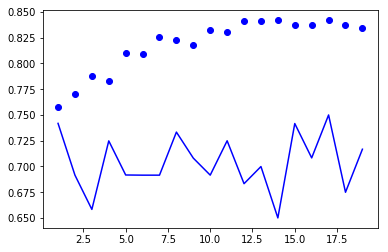

In [144]:
plt.plot(epochs2, acc2, 'bo')
plt.plot(epochs2, val_acc2, 'b')

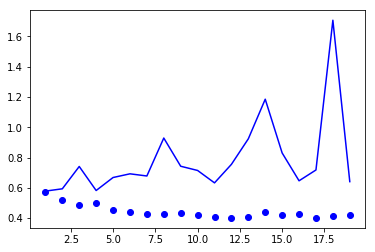

In [146]:
plt.plot(epochs2, loss2, 'bo')
plt.plot(epochs2, val_loss2, 'b')

In [ ]:
##########

In [125]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [126]:
epochs = range(1, len(acc) + 1)

In [127]:
epochs

range(1, 11)

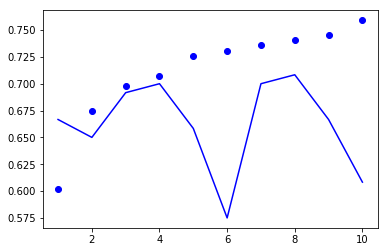

In [128]:
plt.plot(epochs, acc, 'bo')
plt.plot(epochs, val_acc, 'b')

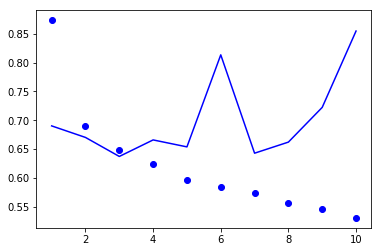

In [129]:
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b')